In [1]:
# !mkdir -p ./aiffel/autoint && wget -O ./aiffel/autoint/ml-1m.zip https://files.grouplens.org/datasets/movielens/ml-1m.zip

In [2]:
# !ls ./aiffel/autoint

In [3]:
# !unzip ./aiffel/autoint/ml-1m.zip -d ./aiffel/autoint

In [4]:
# 라이브러리 호출
import re 
import pandas as pd
# import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumMyeongjo')

In [5]:
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [6]:
data_path = './aiffel/autoint/ml-1m'

In [7]:
# 데이터를 불러옵니다.
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

## 2. 데이터 분석하기

### 1. 데이터 users: user 정보

사용자 정보는 user_id, gender, age, occupation, zip 정보로 구성되어 있습니다.

- user_id: 1부터 6040으로, 익명의 정보로 되어 있음
- gender: M or F
- age: 18세 이하는 1, 18 ~ 24세는 18, 25 ~ 34는 25 등과 같이 구성되어 있음
- occupation: 2는 artist, 8은 farmer 등으로 숫자값으로 매핑되어 있음

In [8]:
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 2. 데이터 ratings: rating 정보
사용자의 평점이 담겨 있는 데이터입니다. 아래와 같이 데이터가 저장되어 있습니다.

- user_id, movie_id, rating, timestamp 컬럼으로 데이터 저장
    - user_id: 1부터 6040으로, 익명의 정보로 되어 있음
    - movie_id: 1부터 3952로, 익명의 정보로 되어 있음
    - rating: 5점 평점
    - timestamp: Unix timestamp로 되어 있음.

In [9]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 3. 데이터 movies: movie 정보
영화 정보가 담겨져 있는 데이터입니다. 아래와 같이 데이터가 저장되어 있습니다.

- movie_id title, genres 컬럼으로 데이터 저장
    - movie_id : 1부터 3952로, 익명의 정보로 되어 있음
    - title: 영화 제목과 연도가 함께 입력되어 있음
    - genres: Action, Comedy 등의 장르가 입력되어 있음

In [10]:
print(movies.shape)
movies.tail() 

(3883, 3)


,movie_id,title,genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


## 2.2 데이터 분석
- 추천시스템 구축에 앞선 사전 데이터 이해
- 데이터가 바라는 방향(분류 or 점수예측), 특징(편향 여부) 등 파악하고 모델 구성해야 함

### 1. 영화 데이터(movies)

- 영화 데이터에는 영화 ID(movie_id), 영화 제목(title), 장르(genres)의 정보만 포함됨
- 정보 분리하여 연도별 분석, 장르별 분석 실행


In [11]:
# 제목과 연도 분리
# 정규표현식, 괄호 안 숫자 4개 뽑아주세요
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [12]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [13]:
# 장르 분리
#  'Animation|Children's|Comedy' : | 기준 장르 분리
movies['genres_split'] = movies['genres'].apply(lambda x: x.split('|'))
movies_exploded = movies.explode('genres_split')
movies_exploded.head(10)

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Romance
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Drama


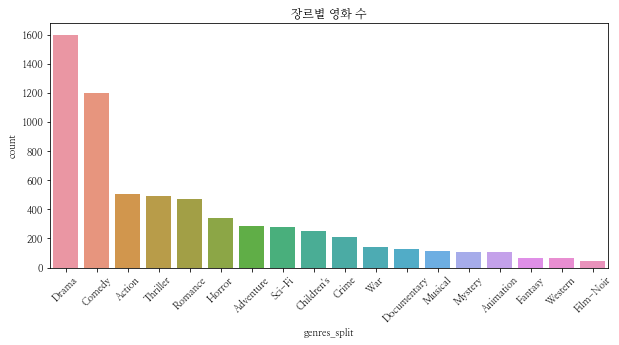

In [14]:
# 장르별 영화 개수 x:장르, y:개수
sns.countplot(x='genres_split', data=movies_exploded, order = movies_exploded['genres_split'].value_counts().index)

plt.gcf().set_size_inches(10, 4.5)
plt.title('장르별 영화 수')
plt.xticks(rotation=45)
plt.show()

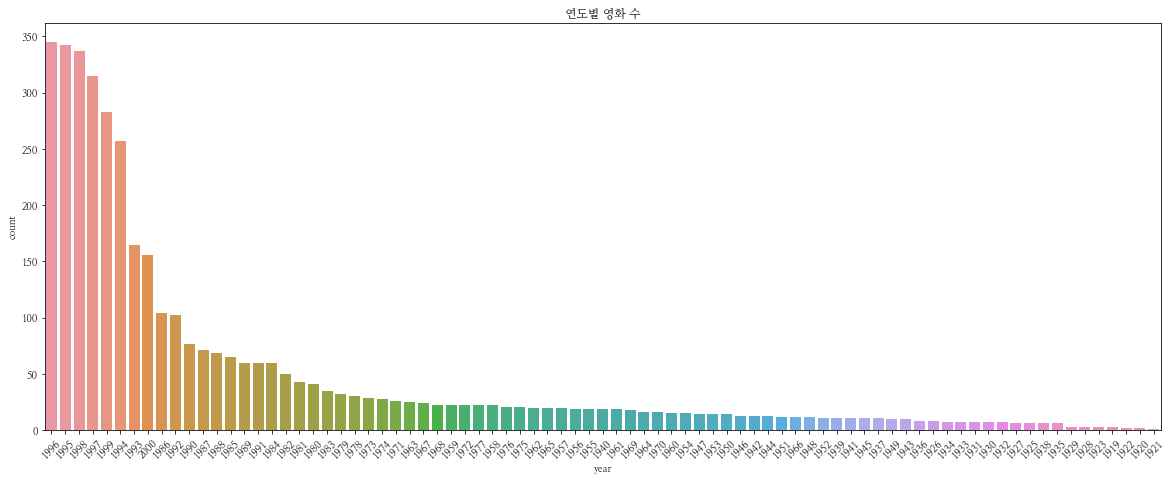

In [15]:
# 연도별 영화 개수 x:연도, y:영화 개수
year_counts = movies['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

year_counts = year_counts.sort_values('count', ascending=False)

sns.barplot(x='year', y='count', data=year_counts)

plt.gcf().set_size_inches(20, 7.5)
plt.title('연도별 영화 수')
plt.xticks(rotation=45)
plt.show()

- 1995~2000년 사이 영화가 가장 많음

### 2. 평점 데이터(ratings)

- 평균 평점, 장르별 평점 등 다양한 관점으로 분석

In [16]:
# movie_id를 기준으로 평점 평균 : groupby
mv_rating_agg = pd.DataFrame(ratings.groupby('movie_id')['rating'].mean())
mv_rating_agg['num_of_ratings'] = pd.DataFrame(ratings.groupby('movie_id')['rating'].count())
mv_rating_agg = mv_rating_agg.reset_index()
mv_rating_agg.columns = ['movie_id', 'avg_rating', 'num_of_ratings']
mv_rating_agg

,movie_id,avg_rating,num_of_ratings
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


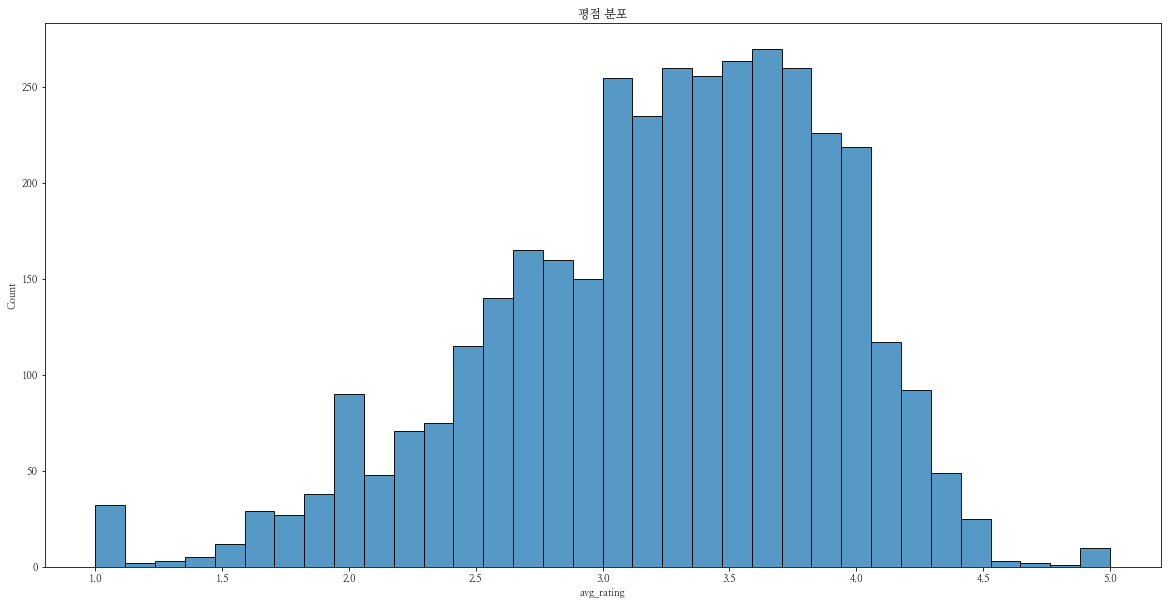

In [17]:
# 평균 평점별 영화 수 
# x:평균평점, y:영화 개수
sns.histplot(mv_rating_agg['avg_rating'], kde=False)
plt.gcf().set_size_inches(20, 10)
plt.title('평점 분포')
plt.show()

- 정규 분포 형태는 나오지 않음
- 1점, 5점 매우 작음 3.5점 분포가 가장 많음

### 3. 장르별 평점 분포

- 'Toy Story (1995)' 3개(Animation, Children's, Comedy)의 장르
    - 토이스토리 평점 : 4점 ⇢ 각 장르 점수도 4점이라 가정
      
1. 영화 평점 데이터와 영화 데이터를 합쳐준다.
2. genre_split를 기준으로 groupby한다.
3. groupby할 때 rating을 기준으로 평균(mean)과 개수(count)를 뽑아낸다.
4. rating과 mean을 기준으로 정렬한다.

In [18]:
rating_by_genre_df = pd.merge(ratings[['movie_id', 'rating']] ,movies_exploded[['movie_id', 'genres_split']] ,on='movie_id').groupby('genres_split').agg({'rating': ['mean', 'count']}).sort_values(('rating', 'mean')).reset_index()
rating_by_genre_df

genres_split    rating        
                     mean   count
0        Horror  3.215013   76386
1    Children's  3.422035   72186
2       Fantasy  3.447371   36301
3        Sci-Fi  3.466521  157294
4     Adventure  3.477257  133953
5        Action  3.491185  257457
6        Comedy  3.522099  356580
7      Thriller  3.570466  189680
8       Romance  3.607465  147523
9       Western  3.637770   20683
10      Musical  3.665519   41533
11      Mystery  3.668102   40178
12    Animation  3.684868   43293
13        Crime  3.708679   79541
14        Drama  3.766332  354529
15          War  3.893327   68527
16  Documentary  3.933123    7910
17    Film-Noir  4.075188   18261

In [19]:
rating_by_genre_df.columns

MultiIndex([('genres_split',      ''),
            (      'rating',  'mean'),
            (      'rating', 'count')],
           )

- '평점의 평균'과 '평점의 개수'를 동시에 구하다보니 '평점(rating)' 값이 겹치게 되면서 데이터프레임 인덱스 2개 됨

In [20]:
for col in rating_by_genre_df.columns.values:
    if col[0] == 'rating':
        print('_'.join(col).strip())
    else:
        print(col[0])

genres_split
rating_mean
rating_count


In [21]:
rating_by_genre_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in rating_by_genre_df.columns.values]    
rating_by_genre_df

,genres_split,rating_mean,rating_count
0,Horror,3.215013,76386
1,Children's,3.422035,72186
2,Fantasy,3.447371,36301
3,Sci-Fi,3.466521,157294
4,Adventure,3.477257,133953
5,Action,3.491185,257457
6,Comedy,3.522099,356580
7,Thriller,3.570466,189680
8,Romance,3.607465,147523
9,Western,3.637770,20683


- ol[0]의 값이 rating이면 _ 를 기준으로 데이터를 묶어달라

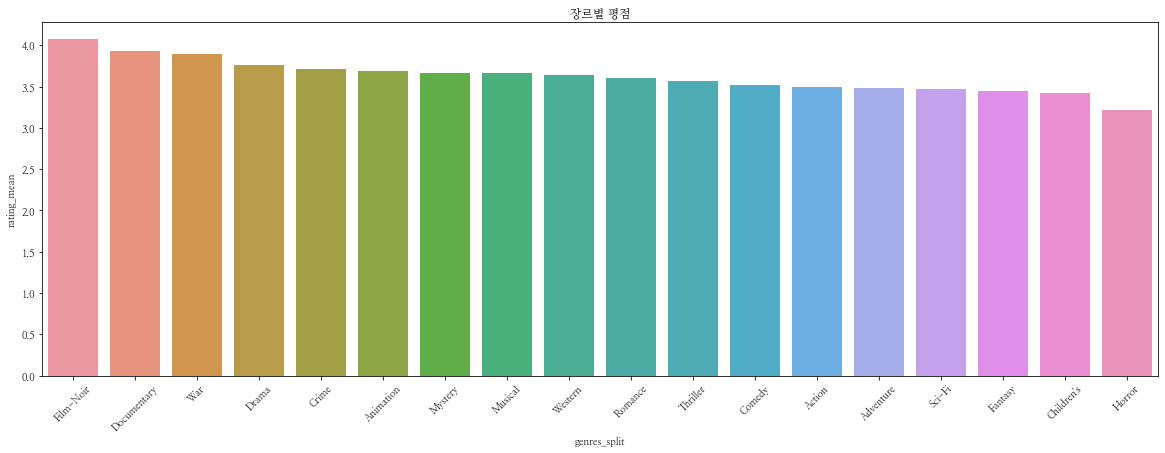

In [22]:
# 장르별 평점
# x:장르, y:평균 평점
rating_by_genre_df_sorted_by_mean = rating_by_genre_df.sort_values('rating_mean', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_mean', data=rating_by_genre_df_sorted_by_mean)
plt.title('장르별 평점')
plt.xticks(rotation=45)
plt.show()

- 비슷한 평점
- 호러물은 다른 장르에 비해 평점이 낮은 편

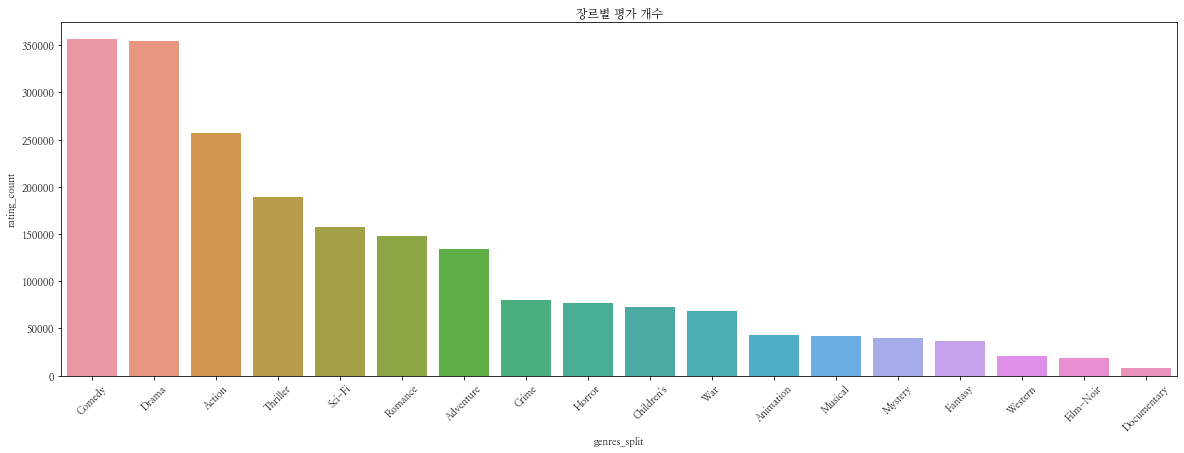

In [23]:
# 다큐멘터리 평점
# 장르별로 평가 개수, x축: 장르, y축: 평가 개수
rating_by_genre_df_sorted_by_count = rating_by_genre_df.sort_values('rating_count', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_count', data=rating_by_genre_df_sorted_by_count)
plt.title('장르별 평가 개수')
plt.xticks(rotation=45)
plt.show()

- 높은 평점을 보인 다큐멘터리 장르가 확연히 적다
- 편향된 데이터일 수 있다
- 혹은 다큐멘터리 영화를 본 사용자는 확실한 취향이 있을 수 있음!

### 데이터 분석 마무리

- 사용자 데이터(users)와 사용자가 가지고 있는 직업(occupation)을 매핑해서 데이터를 깊게 살펴보고 싶다면 사용

In [24]:
# Occupation
occupation_map = {
    0:"other or not specified",
    1:"academic/educator",
    2:"artist",
    3:"clerical/admin",
    4:"college/grad student",
    5:"customer service",
    6:"doctor/health care",
    7:"executive/managerial",
    8:"farmer",
    9:"homemaker",
    10:"K-12 student",
    11:"lawyer",
    12:"programmer",
    13:"retired",
    14:"sales/marketing",
    15:"scientist",
    16:"self-employed",
    17:"technician/engineer",
    18:"tradesman/craftsman",
    19:"unemployed",
    20:"writer"
}

In [25]:
users['occupation_nm'] = users['occupation'].map(occupation_map)
users.head()

,user_id,gender,age,occupation,zip,occupation_nm
0,1,F,1,10,48067,K-12 student
1,2,M,56,16,70072,self-employed
2,3,M,25,15,55117,scientist
3,4,M,45,7,02460,executive/managerial
4,5,M,25,20,55455,writer


## 3. 데이터 전처리

- 다음과 같은 피처(feature)들에 대해 상호작용 모델링
    - 사용자 : 사용자 ID, 성별, 나이, 지역, 직업
    - 영화 : 영화 ID, 장르, 시기
    - 평점 : 사용자 ID, 영화 ID, 평점, 시기
    
😆 '어떤 사용자가 어떤 영화를 언제, 몇 점의 평가를 주었다'는 상호작용 데이터 활용

In [26]:
# 라이브러리 호출  
import re 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import random
plt.rc('font', family='NanumMyeongjo')

In [27]:
# 컬럼 정보 지정
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [28]:
# 데이터 불러오기 
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

In [29]:
# 사용자 데이터 확인
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [30]:
# 영화 데이터 확인
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
# 평점 데이터 확인
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 3.2 영화 데이터 전처리

- 

In [32]:
# 제목 뒤에 붙어 있는 연도를 정규표현식을 활용해 추출합니다. 
# 년대 추출
movies['movie_year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies.head()

,movie_id,title,genres,movie_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


제목에서 영화의 연도를 뽑아낸다 ⇢ 연도에서 연도를 10으로 나눈 나머지를 빼면 년대이다.

    예) 1995년 영화
    1995 % 10 = 5
    1995 - 5 = 1990 ➔ 90년대 영화

In [33]:
a = 1995 % 10
b = 1995 - a

print(a)
print(b)

5
1990


In [34]:
# 90년대 영화, 2000년대 영화 등과 같은 년대 정보를 추출합니다. 
movies['movie_decade'] = movies['title'].str.extract(r'\((\d{4})\)')[0].astype(int).apply(lambda x: str(x - (x % 10)) + 's')
# title 컬럼에서 연도 정보를 빼고 제목만 따로 추출합니다.
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))

In [35]:
movies.head()

,movie_id,title,genres,movie_year,movie_decade
0,1,Toy Story,Animation|Children's|Comedy,1995,1990s
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1990s
2,3,Grumpier Old Men,Comedy|Romance,1995,1990s
3,4,Waiting to Exhale,Comedy|Drama,1995,1990s
4,5,Father of the Bride Part II,Comedy,1995,1990s


- 이전에는 분리된 장르를 행(row)에 추가하였다면, 이번에는 컬럼(열)에 추가
- 이렇게 구성하는 이유는 나중에 모델 input에 넣을 때 편리하기 때문

In [36]:
# | 기호를 기준으로 장르 데이터를 분리합니다. 
genres_split = movies['genres'].str.split('|')

In [37]:
max_genres = genres_split.apply(len).max() 

# 각 장르별로 새로운 컬럼을 생성합니다.
for i in range(max_genres):
    movies[f'genre{i + 1}'] = genres_split.apply(lambda x: x[i] if i < len(x) else None)

# 원래 있던 장르 컬럼은 날려줍니다.
movies.drop('genres', axis=1, inplace=True)

# None은 공백으로 채웁니다.
movies.fillna('', inplace=True)

In [38]:
print(movies.shape)
movies.head()

(3883, 10)


,movie_id,title,movie_year,movie_decade,genre1,genre2,genre3,genre4,genre5,genre6
0,1,Toy Story,1995,1990s,Animation,Children's,Comedy,,,
1,2,Jumanji,1995,1990s,Adventure,Children's,Fantasy,,,
2,3,Grumpier Old Men,1995,1990s,Comedy,Romance,,,,
3,4,Waiting to Exhale,1995,1990s,Comedy,Drama,,,,
4,5,Father of the Bride Part II,1995,1990s,Comedy,,,,,


In [39]:
# 모든 장르의 종류
set(movies['genre1'].unique().tolist() + movies['genre2'].unique().tolist() + movies['genre3'].unique().tolist())

{'',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### 3.3 평점 데이터 전처리

In [40]:
timestamp = 978300760 
dt_object = datetime.fromtimestamp(timestamp)

print(dt_object.strftime("%Y-%m-%d"))

2000-12-31


In [41]:
ratings['timestamp'] = ratings['timestamp'].apply(lambda x : datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,2000-12-31
1,1,661,3,2000-12-31
2,1,914,3,2000-12-31
3,1,3408,4,2000-12-31
4,1,2355,5,2001-01-06


In [42]:
ratings['rating_year'] = ratings['timestamp'].apply(lambda x : x.split("-")[0]) 
ratings['rating_month'] = ratings['timestamp'].apply(lambda x : x.split("-")[1])
ratings['rating_decade'] = ratings['rating_year'].astype(int).apply(lambda x: str(x - (x % 10)) + 's')

In [43]:
ratings.head()

,user_id,movie_id,rating,timestamp,rating_year,rating_month,rating_decade
0,1,1193,5,2000-12-31,2000,12,2000s
1,1,661,3,2000-12-31,2000,12,2000s
2,1,914,3,2000-12-31,2000,12,2000s
3,1,3408,4,2000-12-31,2000,12,2000s
4,1,2355,5,2001-01-06,2001,01,2000s


In [44]:
# 임시 저장 
movies.to_csv(f"{data_path}/movies_prepro.csv", index=False)
ratings.to_csv(f"{data_path}/ratings_prepro.csv", index=False)
users.to_csv(f"{data_path}/users_prepro.csv", index=False)

In [45]:
!ls ./aiffel/autoint/ml-1m

movielens_rcmm_v1.csv  movies_prepro.csv   README
movielens_rcmm_v2.csv  ratings.dat	   users.dat
movies.dat	       ratings_prepro.csv  users_prepro.csv


### 3.4 모델 입력 데이터 생성

추천 시스템에 활용되는 데이터는 크게 아래와 같이 구분될 수 있습니다.

1) 명식적 데이터(Explicit data): 사용자가 직접적으로 선호도를 표현한 데이터(예: 평점, 구독, 댓글, 리뷰, 좋아요, 싫어요, 차단 등) \
2) 암묵적 데이터(Implicit data): 사용자가 간접적으로 선호도를 표현한 데이터(예: 클릭 여부, 검색 기록, 방문 페이지, 마우스 움직임, 구매 내역, 시청 시간대 등)

명시적 데이터, 예를 들어 평점 데이터라면 1~5점과 같은 분포로 데이터가 존재하게 되고 이는 이진 분류(binary classification) 문제라기 보다 회귀(regression) 문제나 다중 분류(multiclass classification) 문제라고 볼 수 있을 것입니다.

하지만 암묵적 데이터인 클릭 여부로 보면 어떨까요?

클릭 여부는 '클릭을 했다, 안했다'와 같이 0과 1로 분리할 수 있습니다. 이 때 클릭을 했다는 것은 '선호'한다라는 의미도 담고 있기에, 선호 정보를 모델링한다고도 볼 수 있습니다.

무엇이 정답인지는 따로 정해진 바가 없습니다. 데이터와 서비스 전략에 따라 정답은 달라집니다.

이번 프로젝트에서는 '선호했다'를 기준으로 살펴보려고 합니다.

그런데 여기서 문제가 하나 있습니다. 그럼 '선호했다'라는 정보는 무엇이고 '선호하지 않는다'라는 정보는 무엇일까요? 그리고 그런 데이터가 MovieLens에 있을까요? 이 문제를 풀어나가보려고 합니다.

### 3.4.1 랜덤 샘플링 기반 방법


In [46]:
# 1. 3점 이상의 점수를 부여한 영화를 '선호'영화라고 가정하고, 이를 label=1로 생성합니다.
ratings = ratings[ratings['rating'] >= 3]
ratings['label'] = 1
ratings.drop('rating', axis=1, inplace=True)
print(ratings.shape)
ratings.head()

(836478, 7)


,user_id,movie_id,timestamp,rating_year,rating_month,rating_decade,label
0,1,1193,2000-12-31,2000,12,2000s,1
1,1,661,2000-12-31,2000,12,2000s,1
2,1,914,2000-12-31,2000,12,2000s,1
3,1,3408,2000-12-31,2000,12,2000s,1
4,1,2355,2001-01-06,2001,01,2000s,1


In [47]:
# 1. 사용자가 봤던(선호했던) 영화 리스트를 추출합니다. 사용자마다 평점이 3점 이상인 영화 리스트가 구성됩니다. 
user_seen_movies = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
user_seen_movies.head()

,user_id,movie_id
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,..."


In [48]:
# 2. 먼저 고유 영화와 고유 사용자들을 가지고 옵니다. 
unique_movies = movies['movie_id'].unique()
unique_users = users['user_id'].unique()
negative_users = []
negative_movies = []
negative_labels = []

# 사용자별로 하나씩 진행합니다.
for user in unique_users:
    # 충분한 이력이 없는 사용자는 넘어갑니다. 충분한 이력이 없는 사용자 데이터는 훈련에 방해가 되고 overfitting 등이 될 수 있습니다.
    if len(user_seen_movies[user_seen_movies['user_id'] == user]) < 1:
        continue
    # 2-1. 해당 사용자가 선호하는 영화 리스트를 가지고 옵니다.
    user_seen_movie_list = user_seen_movies[user_seen_movies['user_id'] == user]['movie_id'].values[0]
    # 2-2. 전체 영화 중 사용자가 선호한 영화 정보를 제외합니다.
    user_non_seen_movie_list = list(set(unique_movies) - set(user_seen_movie_list))
    # 2-3. 선호 영화 1개당 비선호 영화 5개를 추출합니다. 
    sample_pop_size = len(user_seen_movie_list)*5
    # 만약 비선호 영화 샘플 개수가 전체 영화 개수보다 크면, 비선호 영화 샘플 개수는 전체 영화 개수에서 사용자가 선호한 영화의 개수를 뺀 값(해당 사용자 입장에선 샘플링 최대 값)으로 설정합니다.
    if len(unique_movies) - len(user_seen_movie_list) < len(user_seen_movie_list)*5 :
        sample_pop_size = len(unique_movies) - len(user_seen_movie_list)
    # 랜덤으로 추출합니다. 
    user_negative_movie_list = random.sample(user_non_seen_movie_list, sample_pop_size)
    
    # 해당 값들을 리스트에 저장합니다.
    negative_users += [user for _ in range(len(user_negative_movie_list))]
    negative_movies += user_negative_movie_list
    negative_labels += [0 for _ in range(len(user_negative_movie_list))]

- 이렇게 만들어진 리스트는 사용자가 '비선호'한다는 정보를 담고 있습니다. 따라서, label도 0입니다.
- 이제 이 데이터를 하나의 데이터프레임으로 만들고 사용자 선호 정보와 합쳐주면 0과 1이 조합된 훈련 데이터가 만들어 집니다.

In [49]:
print(len(negative_users))
print(len(negative_movies))
print(len(negative_labels))

4068124
4068124
4068124


In [50]:
negative_ratings_df = pd.DataFrame({'user_id' : negative_users, 'movie_id' : negative_movies, 'label':negative_labels})
print(negative_ratings_df.shape)
negative_ratings_df.head()

(4068124, 3)


,user_id,movie_id,label
0,1,187,0
1,1,3699,0
2,1,3029,0
3,1,1422,0
4,1,954,0


- 최종적으로 모델 훈련에 사용하는 데이터를 구성하기 위해서 필요한 컬럼만 추출해 활용합니다. 필요한 컬럼은 아래와 같습니다.

    - 평점 : 사용자 ID, 영화 ID, 레이블(label)
    - 영화 : 영화 ID, 년대, 년도, 장르1
    - 사용자 : 사용자 ID, 성별, 나이, 지역, 직업

이 데이터를 모아 하나로 합쳐줍니다.

In [51]:
ratings_df = ratings[['user_id', 'movie_id', 'label']] 
ratings_df = pd.concat([ratings_df, negative_ratings_df], axis=0)
movies_df = movies[['movie_id', 'movie_decade', 'movie_year', 'genre1']]
movies_df.columns = ['movie_id', 'decade', 'movie_year', 'genre']
user_df = users[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [52]:
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, user_df, on='user_id')
merge_mlens_data.dropna(inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,label,decade,movie_year,genre,gender,age,occupation,zip
0,1,1193,1,1970s,1975,Drama,F,1,10,48067
1,1,661,1,1990s,1996,Animation,F,1,10,48067
2,1,914,1,1960s,1964,Musical,F,1,10,48067
3,1,3408,1,2000s,2000,Drama,F,1,10,48067
4,1,2355,1,1990s,1998,Animation,F,1,10,48067


In [53]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','decade', 'movie_year', 'genre', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,decade,movie_year,genre,gender,age,occupation,zip,label
0,1,1193,1970s,1975,Drama,F,1,10,48067,1
1,1,661,1990s,1996,Animation,F,1,10,48067,1
2,1,914,1960s,1964,Musical,F,1,10,48067,1
3,1,3408,2000s,2000,Drama,F,1,10,48067,1
4,1,2355,1990s,1998,Animation,F,1,10,48067,1


In [54]:
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v1.csv', index=False)

In [55]:
!ls -l ./aiffel/autoint/ml-1m

total 332936
-rw-r--r-- 1 root root 211800303 Apr  9 12:50 movielens_rcmm_v1.csv
-rw-r--r-- 1 root root  67335303 Apr  9 12:44 movielens_rcmm_v2.csv
-rw-r----- 1 root root    171308 Mar 26  2003 movies.dat
-rw-r--r-- 1 root root    198094 Apr  9 12:50 movies_prepro.csv
-rw-r----- 1 root root  24594131 Feb 28  2003 ratings.dat
-rw-r--r-- 1 root root  36558754 Apr  9 12:50 ratings_prepro.csv
-rw-r----- 1 root root      5577 Jan 29  2016 README
-rw-r----- 1 root root    134368 Feb 28  2003 users.dat
-rw-r--r-- 1 root root    110242 Apr  9 12:50 users_prepro.csv


### 3.4.2 선호도로 나누기

'1. 랜덤 샘플링 기반 방법'은 그리 좋은 방법은 아닙니다. 왜냐하면 사용자 정보를 무작위로 샘플링을 해서 임의로 데이터를 생성했기 때문입니다. 가장 좋은 것은 원본 데이터를 활용하는 것이죠.

따라서 2번째 과정에서는 샘플링을 하지 않고 데이터를 선호도로 나누려고 합니다. 이후 모델을 훈련할 때도 이 데이터를 활용할 것입니다.

먼저 데이터 전처리를 하고 저장했던 데이터를 불러옵시다.

In [56]:
users_df = pd.read_csv(f'{data_path}/users_prepro.csv')
ratings_df = pd.read_csv(f'{data_path}/ratings_prepro.csv')
movies_df = pd.read_csv(f'{data_path}/movies_prepro.csv')

In [57]:
print(users_df.columns)
print(ratings_df.columns)
print(movies_df.columns)

Index(['user_id', 'gender', 'age', 'occupation', 'zip'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'timestamp', 'rating_year',
       'rating_month', 'rating_decade'],
      dtype='object')
Index(['movie_id', 'title', 'movie_year', 'movie_decade', 'genre1', 'genre2',
       'genre3', 'genre4', 'genre5', 'genre6'],
      dtype='object')


1번 과정에서는 평점이 3점 이상인 데이터를 label=1로 설정하고 label=0은 랜덤 샘플링으로 추출했는데요, 이번 과정에서는 다음과 같은 순서로 데이터 선호도를 구성합니다.

1. 평점이 4점 이상인 데이터를 label=1, 나머지를 label=0
2. 필요한 데이터만 추출하고 저장

In [58]:
# 1. 4점 이상인 데이터를 1로, 아닌 데이터를 0으로 설정합니다.  
ratings_df['label'] = ratings_df['rating'].apply(lambda x : x >=4).astype(int)

ratings_df = ratings_df[['user_id', 'movie_id', 'rating_year','rating_month', 'rating_decade', 'label']]
ratings_df.head()

,user_id,movie_id,rating_year,rating_month,rating_decade,label
0,1,1193,2000,12,2000s,1
1,1,661,2000,12,2000s,0
2,1,914,2000,12,2000s,0
3,1,3408,2000,12,2000s,1
4,1,2355,2001,1,2000s,1


In [59]:
# 2. 필요 데이터만 가지고 옵니다. 특히 장르는 3개만 가지고 와서 활용합니다.  
movies_df = movies_df[['movie_id', 'movie_decade', 'movie_year', 'genre1', 'genre2', 'genre3']]
users_df = users_df[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [60]:
# 필요한 데이터를 합쳐줍니다.   
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, users_df, on='user_id')
merge_mlens_data.fillna('no', inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,rating_year,rating_month,rating_decade,label,movie_decade,movie_year,genre1,genre2,genre3,gender,age,occupation,zip
0,1,1193,2000,12,2000s,1,1970s,1975,Drama,no,no,F,1,10,48067
1,1,661,2000,12,2000s,0,1990s,1996,Animation,Children's,Musical,F,1,10,48067
2,1,914,2000,12,2000s,0,1960s,1964,Musical,Romance,no,F,1,10,48067
3,1,3408,2000,12,2000s,1,2000s,2000,Drama,no,no,F,1,10,48067
4,1,2355,2001,1,2000s,1,1990s,1998,Animation,Children's,Comedy,F,1,10,48067


In [61]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2000,12,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2000,12,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2000,12,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2000,12,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [62]:
# 저장합니다.
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v2.csv', index=False)

## 4. AutoInt 모델 구현 및 학습

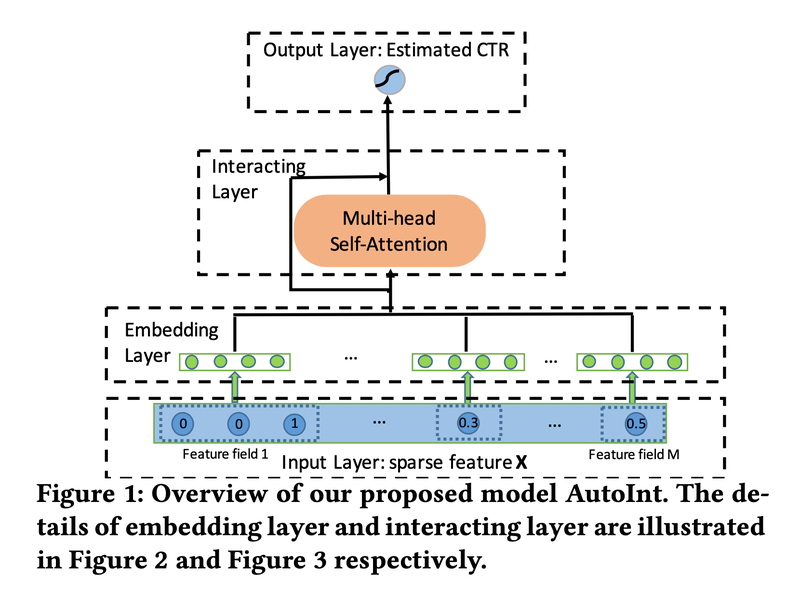

In [63]:
import time
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

In [64]:
# 임베딩 레이어
class FeaturesEmbedding(Layer):  
    '''
    임베딩 레이어입니다. 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됩니다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 됩니다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.longlong)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화합니다.
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져니다.
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

In [65]:
# 다층 퍼셉트론
class MultiLayerPerceptron(Layer):  
    '''
    DNN 레이어입니다.
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조입니다.
    - 필요에 따라 배치 정규화도 사용할 수 있습니다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올립니다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수를 세팅합니다.
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행합니다.
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 됩니다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합을 방지합니다.
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

In [66]:
class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어입니다.
    - 위에 작성한 수식과 같이 동작됩니다.
    - 필요에 따라 잔차 연결(residual connection)도 진행합니다.
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스입니다. 
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스입니다.
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스입니다.
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있습니다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 옵니다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터를 분리해줍니다.
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해줍니다. 위 이미지의 식 (5)와 같습니다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해줍니다. 식 (6)과 같습니다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아줍니다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 그 결과 값을 리턴합니다.

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

### 3.4.2 AutoInt 모델


In [67]:
class AutoInt(Layer): 
    '''
     AutoInt 본체입니다. 앞서서 정의한 layer를 가져와서 계산을 수행합니다.
    '''
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, 
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoInt, self).__init__()
        # 임베딩 레이어를 정의합니다. 
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        # 마지막 출력 레이어를 정의합니다.
        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        # 멀티 레이어 퍼셉트론 레이어를 정의합니다.
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        # input 데이터에 해당되는 embedding 값을 가져옵니다.
        att_input = self.embedding(inputs)
        # 멀티 헤드 셀프 어텐션 레이어에서 상호작용을 수행합니다.
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        # 최종 출력입니다. 
        att_output = self.final_layer(att_output)
        # sigmoid로 예측값을 출력합니다.
        y_pred = tf.nn.sigmoid(att_output)

        return y_pred

### 3.4.3 평가 지표


In [68]:
# 평가 함수는 아래의 링크에서 가져왔습니다.
# https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

### 모델테스트

In [69]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

### 데이터 불러오기 및 세팅

- 전처리한 데이터 불러오기

1. 데이터 불러오기
2. 레이블 인코더(label encoder)를 통해 0부터 피처(feature)의 고유 개수까지 매핑
    - 예) 성별: 남(M), 여(F)를 0, 1로 변환
    - 예) 장르: 코메디, 드라마, 액션을 0, 1, 2로 변환
3. 학습(train) 데이터와 테스트(test) 데이터로 분리

In [70]:
# 1. 데이터 불러오기
# csv 데이터이므로 read_csv로 가져옵니다.
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2000,12,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2000,12,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2000,12,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2000,12,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [71]:
# 2. 라벨 인코더(label encoder)
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킵니다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [72]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,0,3,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,0,3,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,0,3,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,0,3,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [73]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [74]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int64  
 1   movie_id       800167 non-null  int64  
 2   movie_decade   800167 non-null  int64  
 3   movie_year     800167 non-null  int64  
 4   rating_year    800167 non-null  int64  
 5   rating_month   800167 non-null  int64  
 6   rating_decade  800167 non-null  int64  
 7   genre1         800167 non-null  int64  
 8   genre2         800167 non-null  int64  
 9   genre3         800167 non-null  int64  
 10  gender         800167 non-null  int64  
 11  age            800167 non-null  int64  
 12  occupation     800167 non-null  int64  
 13  zip            800167 non-null  int64  
 14  label          800167 non-null  float32
dtypes: float32(1), int64(14)
memory usage: 94.6 MB


In [76]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다. 
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439])

### 훈련 환경 및 모델 세팅

- 훈련에 앞서 환경 세팅

1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

두 가지 정의 

In [77]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=5
learning_rate= 0.0001
dropout= 0.4
batch_size = 2048
embed_dim= 16

In [78]:
# AutoInt 레이어를 가지고 있는 모델 본체입니다. 해당 모델을 활용해 훈련을 진행합니다.
class AutoIntModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2
                 , att_res=True, l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                 , dnn_dropout=0, init_std=0.0001):
        super(AutoIntModel, self).__init__()
        self.autoInt_layer = AutoInt(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                     att_res=att_res, l2_reg_dnn=l2_reg_dnn, dnn_dropout=dnn_dropout, init_std=init_std
                                    )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

In [79]:
# 모델 정의
autoInt_model = AutoIntModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                             , dnn_dropout=dropout, init_std=0.0001)

In [80]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [81]:
autoInt_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

### 훈련 및 평가

- 훈련 후에는 NDCG와 Hitrate를 활용해 평가 진행

In [82]:
history = autoInt_model.fit(train_df[u_i_feature + meta_features], train_df[label], epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
352/352 [==============================] - 18s 14ms/step - loss: 0.6736 - binary_crossentropy: 0.6736 - val_loss: 0.6307 - val_binary_crossentropy: 0.6307
Epoch 2/5
352/352 [==============================] - 4s 12ms/step - loss: 0.6034 - binary_crossentropy: 0.6034 - val_loss: 0.5915 - val_binary_crossentropy: 0.5915
Epoch 3/5
352/352 [==============================] - 4s 13ms/step - loss: 0.5686 - binary_crossentropy: 0.5686 - val_loss: 0.5562 - val_binary_crossentropy: 0.5562
Epoch 4/5
352/352 [==============================] - 4s 13ms/step - loss: 0.5418 - binary_crossentropy: 0.5418 - val_loss: 0.5469 - val_binary_crossentropy: 0.5469
Epoch 5/5
352/352 [==============================] - 5s 13ms/step - loss: 0.5354 - binary_crossentropy: 0.5354 - val_loss: 0.5439 - val_binary_crossentropy: 0.5439


In [83]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 옵니다. 
mymodel_user_pred_info = test_model(autoInt_model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

100%|██████████| 6035/6035 [00:00<00:00, 72436.03it/s]


In [84]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 23354.25it/s]


In [85]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66278
 mymodel hitrate :  0.63294


### 저장

In [86]:
np.save('./aiffel/autoint/field_dims.npy', field_dims)

In [87]:
# 모델 저장을 위해, autoint 폴더 안에 model 폴더를 생성합니다.
!mkdir ./aiffel/autoint/model/

모델의 가중치(weight) 저장

In [88]:
autoInt_model.save_weights('./aiffel/autoint/model/autoInt_model_weights.h5')

- 모델을 저장할 때는 모델 객체도 저장해 두어야 합니다. 모델 객체는 joblib.dump를 이용하여 pickled binary file 형태로 저장하면 됨

In [90]:
import joblib 

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, './aiffel/autoint/label_encoders.pkl')

['./aiffel/autoint/label_encoders.pkl']

## 5. 스트림릿을 사용한 시각화
